In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import statsmodels 
import seaborn as sns
import scipy.stats as ss
import pylab
import pymysql
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
import sklearn
import arch
import datetime as dt


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from tqdm import tqdm
from time import sleep
sns.set()

In [2]:
def read_csv(name:str):
    df = pd.read_csv(f'../data/processed/{name}.csv')
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace = True)
    df.asfreq('12H')
    return df

In [3]:
data_raw = read_csv('data_processed')
df = data_raw.copy()

In [4]:
df.head()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Ret_cum_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Ret_cum_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Ret_cum_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Ret_cum_BNBUSDT,Norm_BNBUSDT
Date,,,,,,,,,,,,,,,,
2018-06-01 00:00:00,7361.39,570.63,0.21580,13.7800,NaN,NaN,100.000000,NaN,NaN,100.000000,NaN,NaN,100.000000,NaN,NaN,100.000000
2018-06-01 12:00:00,7521.01,579.00,0.22038,14.2888,2.168340,2.168340,102.168340,1.466800,1.466800,101.466800,2.122335,2.122335,102.122335,3.692308,3.692308,103.692308
2018-06-02 00:00:00,7652.28,592.73,0.22428,14.5000,1.745377,3.913718,103.951563,2.371330,3.838130,103.872912,1.769671,3.892006,103.929564,1.478081,5.170388,105.224964
2018-06-02 12:00:00,7640.03,590.85,0.22648,14.6732,-0.160083,3.753635,103.785155,-0.317176,3.520953,103.543452,0.980917,4.872923,104.949027,1.194483,6.364871,106.481858
2018-06-03 00:00:00,7714.85,619.93,0.23284,14.7861,0.979316,4.732950,104.801539,4.921723,8.442676,108.639574,2.808195,7.681118,107.896200,0.769430,7.134301,107.301161


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2593 entries, 2018-06-01 00:00:00 to 2021-12-18 00:00:00
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BTCUSDT          2593 non-null   float64
 1   ETHUSDT          2593 non-null   float64
 2   ADAUSDT          2593 non-null   float64
 3   BNBUSDT          2593 non-null   float64
 4   Ret_BTCUSDT      2592 non-null   float64
 5   Ret_cum_BTCUSDT  2592 non-null   float64
 6   Norm_BTCUSDT     2593 non-null   float64
 7   Ret_ETHUSDT      2592 non-null   float64
 8   Ret_cum_ETHUSDT  2592 non-null   float64
 9   Norm_ETHUSDT     2593 non-null   float64
 10  Ret_ADAUSDT      2592 non-null   float64
 11  Ret_cum_ADAUSDT  2592 non-null   float64
 12  Norm_ADAUSDT     2593 non-null   float64
 13  Ret_BNBUSDT      2592 non-null   float64
 14  Ret_cum_BNBUSDT  2592 non-null   float64
 15  Norm_BNBUSDT     2593 non-null   float64
dtypes: float64(16)
memory us

In [6]:
df.describe()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Ret_cum_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Ret_cum_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Ret_cum_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Ret_cum_BNBUSDT,Norm_BNBUSDT
count,2593.000000,2593.000000,2593.000000,2593.000000,2592.000000,2592.000000,2593.000000,2592.000000,2592.000000,2593.000000,2592.000000,2592.000000,2593.000000,2592.000000,2592.000000,2593.000000
mean,19041.309973,924.559179,0.464031,114.251214,0.107543,95.953406,258.664600,0.134835,46.128946,162.024285,0.150676,61.227078,215.028459,0.213117,177.044024,829.108955
std,18307.002964,1226.240522,0.714974,180.544934,2.667775,112.919499,248.689486,3.438717,155.085309,214.892403,4.068545,196.884157,331.313149,3.793235,193.571595,1310.195461
min,3201.240000,83.670000,0.022290,4.516000,-23.536521,-73.204783,43.486896,-29.813473,-169.725848,14.662741,-30.108340,-173.410435,10.329008,-31.200628,-91.025486,32.772134
25%,6756.980000,179.680000,0.048720,14.808800,-0.907231,3.358082,91.789458,-1.290592,-70.282631,31.488004,-1.785442,-88.020469,22.576460,-1.466125,57.755101,107.465893
50%,9513.220000,265.710000,0.089610,21.788800,0.112359,61.606996,129.231300,0.072755,-18.977238,46.564324,0.022517,-38.515793,41.524560,0.083087,106.946214,158.119013
75%,33086.630000,1365.360000,0.365710,43.894600,1.156310,222.918889,449.461719,1.698970,193.655761,239.272383,2.011680,190.951871,169.467099,1.889096,219.062543,318.538462
max,67594.980000,4807.980000,3.048000,676.150000,17.633807,311.787068,918.236637,18.345390,364.551722,842.573997,23.258978,466.725618,1412.418906,35.598364,569.890575,4906.748911


In [7]:
df.isna().sum()

BTCUSDT            0
ETHUSDT            0
ADAUSDT            0
BNBUSDT            0
Ret_BTCUSDT        1
Ret_cum_BTCUSDT    1
Norm_BTCUSDT       0
Ret_ETHUSDT        1
Ret_cum_ETHUSDT    1
Norm_ETHUSDT       0
Ret_ADAUSDT        1
Ret_cum_ADAUSDT    1
Norm_ADAUSDT       0
Ret_BNBUSDT        1
Ret_cum_BNBUSDT    1
Norm_BNBUSDT       0
dtype: int64

In [8]:
def plot(df, columns, cumsum = False):
    fig, ax = plt.subplots(figsize=(22, 7))
    for column in columns:
        if cumsum == True:
            df[column].cumsum().plot(ax=ax, label=column)
        else:
            df[column].plot(ax=ax, label=column)
    plt.title(f"Plot of {', '.join(columns)}", fontsize = 20)
    plt.legend(fontsize = 15)
    file_name = "_".join(columns) + "_plot.png"
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()


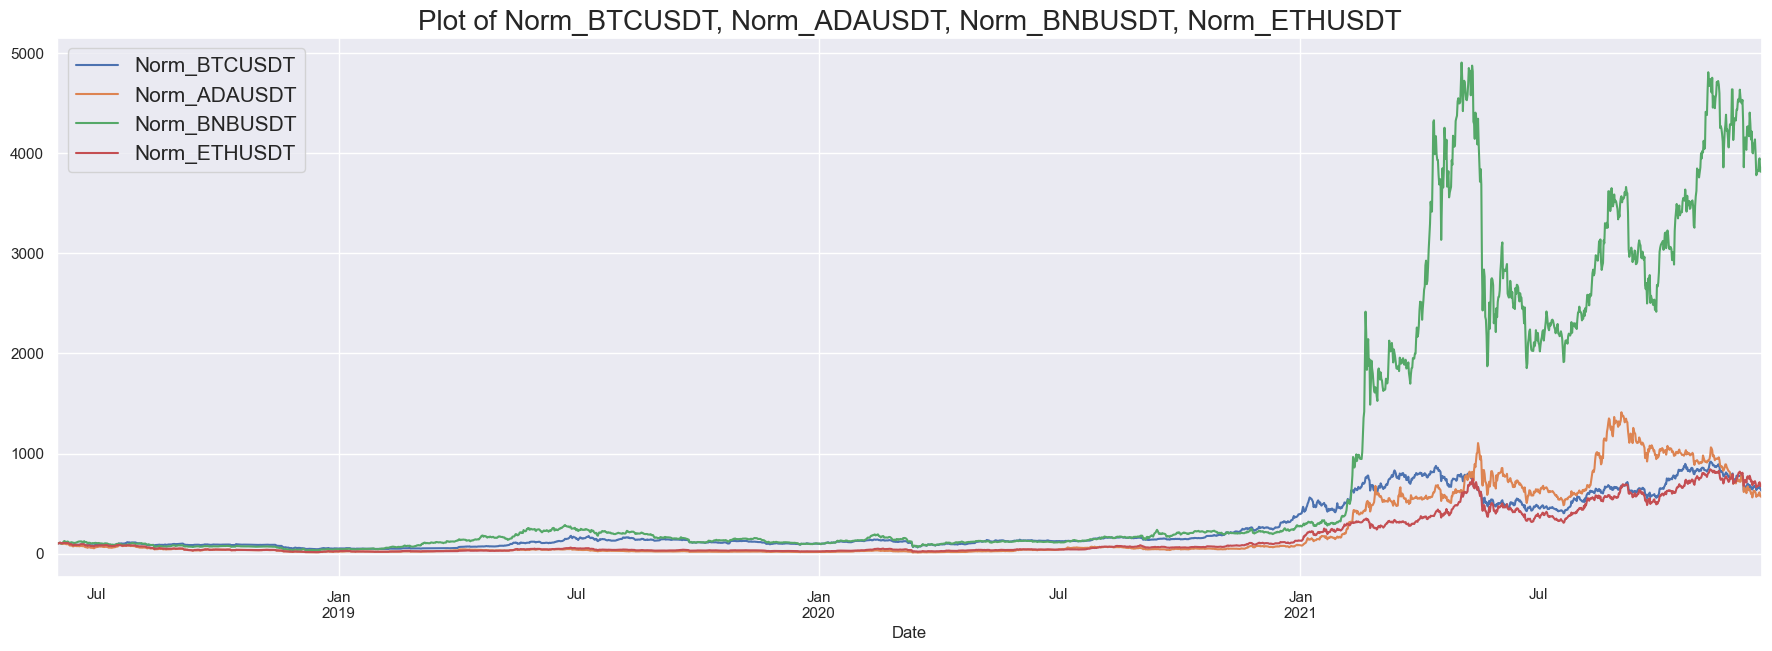

In [9]:
plot(df, ['Norm_BTCUSDT', 'Norm_ADAUSDT', 'Norm_BNBUSDT', 'Norm_ETHUSDT'])

In [10]:
df.BNBUSDT.nlargest()

Date
2021-05-03 12:00:00    676.15
2021-05-11 12:00:00    671.91
2021-05-09 00:00:00    668.61
2021-05-10 00:00:00    664.77
2021-05-12 00:00:00    663.99
Name: BNBUSDT, dtype: float64

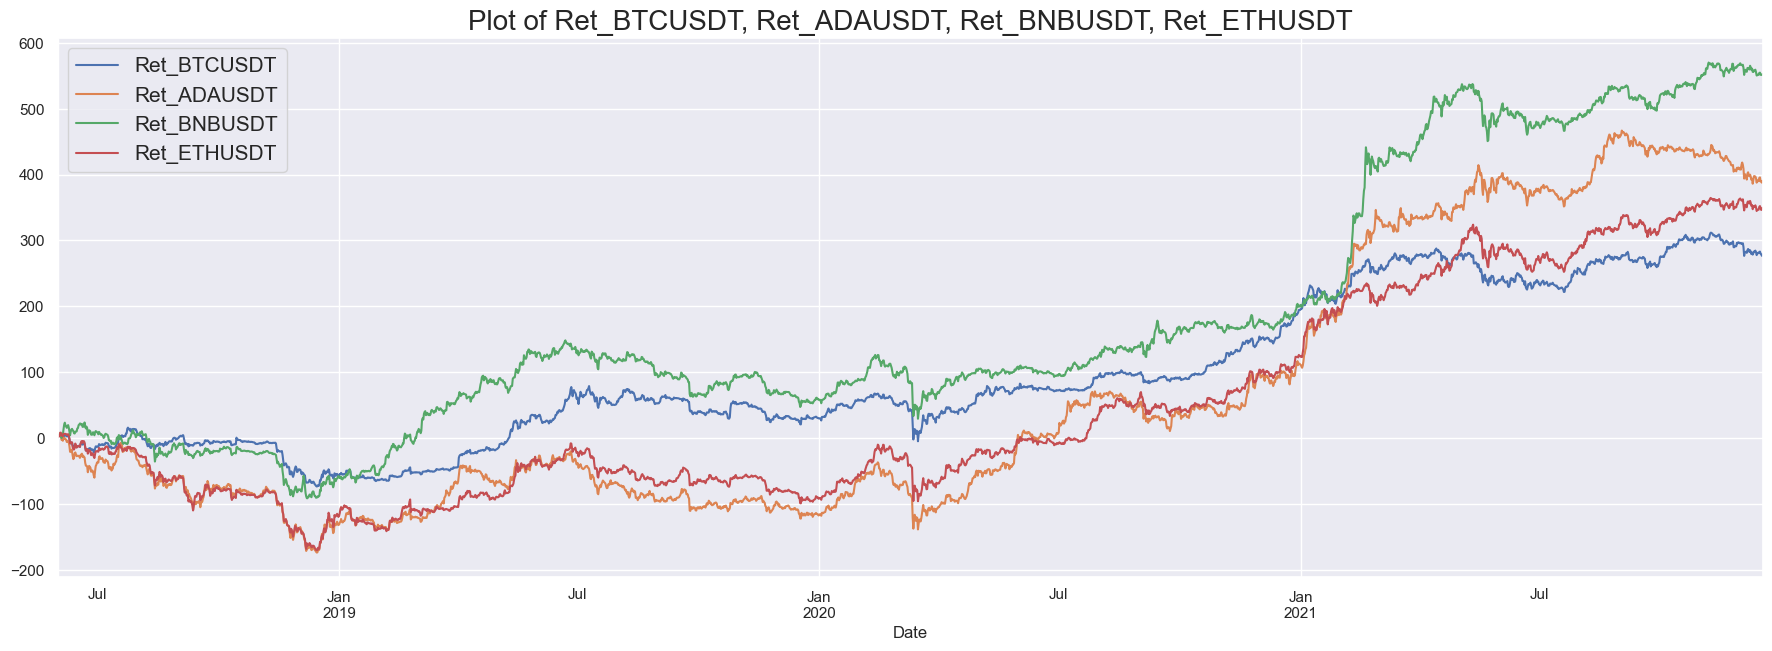

In [11]:
plot(df, ['Ret_BTCUSDT', 'Ret_ADAUSDT', 'Ret_BNBUSDT', 'Ret_ETHUSDT'], cumsum=True)

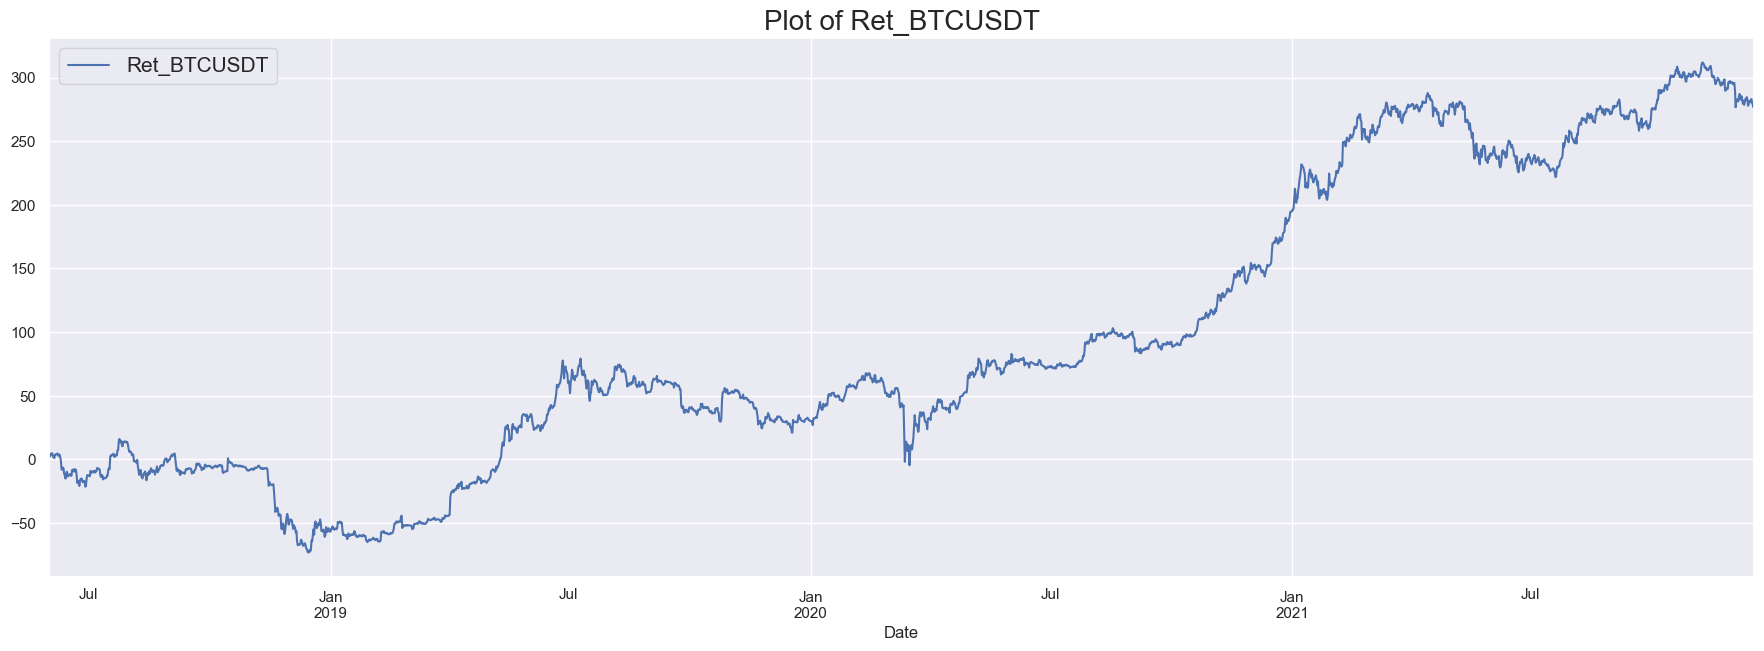

In [12]:
plot(df, ['Ret_BTCUSDT'], cumsum=True)

## QQ Plot

In [13]:
def qqplot(df, column):
    fig, ax = plt.subplots(figsize=(12, 8))
    ss.probplot(df[column], plot=plt)
    plt.title(f"Q-Q Plot of {column}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    
    
    # Generate the file name based on the column name
    file_name = f"{column}_qqplot.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()



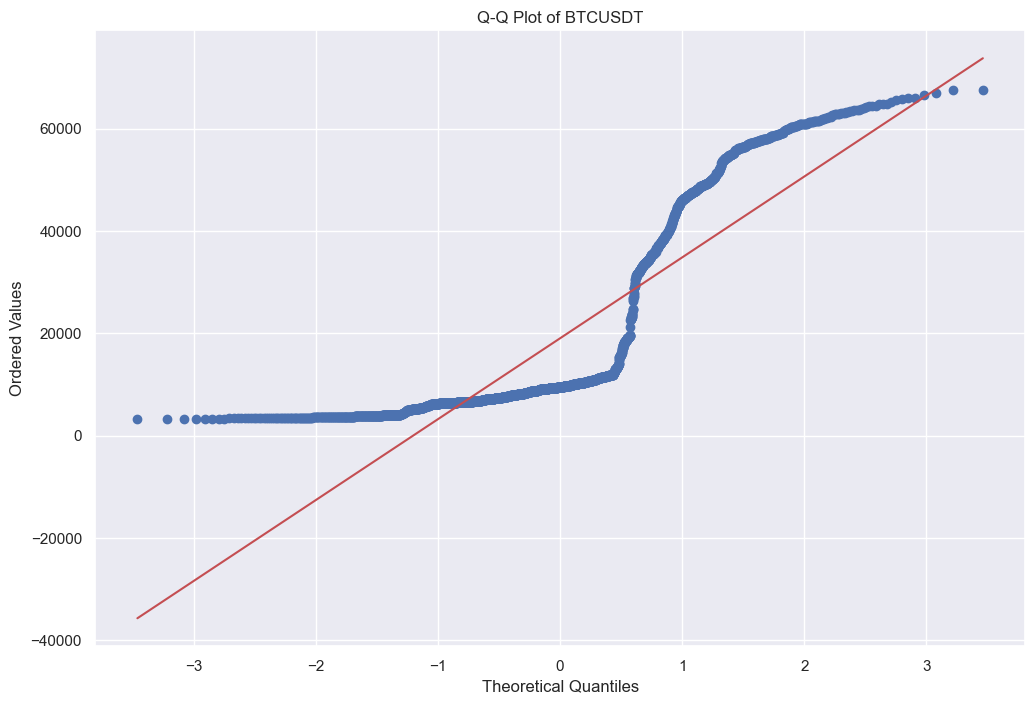

In [14]:
qqplot(df, 'BTCUSDT' )

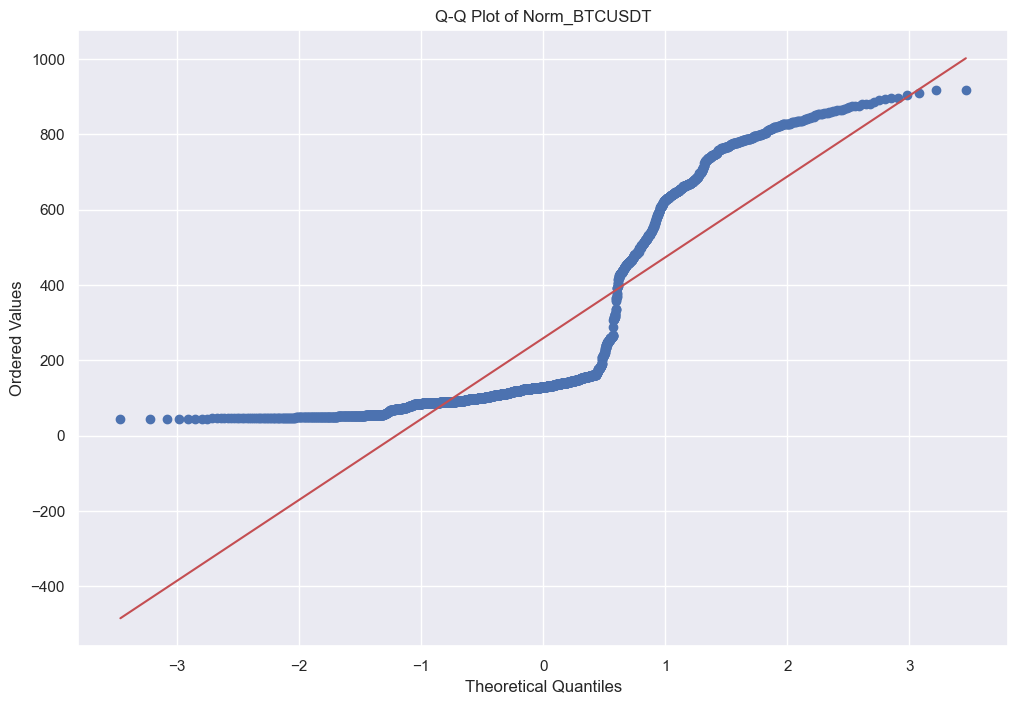

In [15]:
qqplot(df, 'Norm_BTCUSDT')

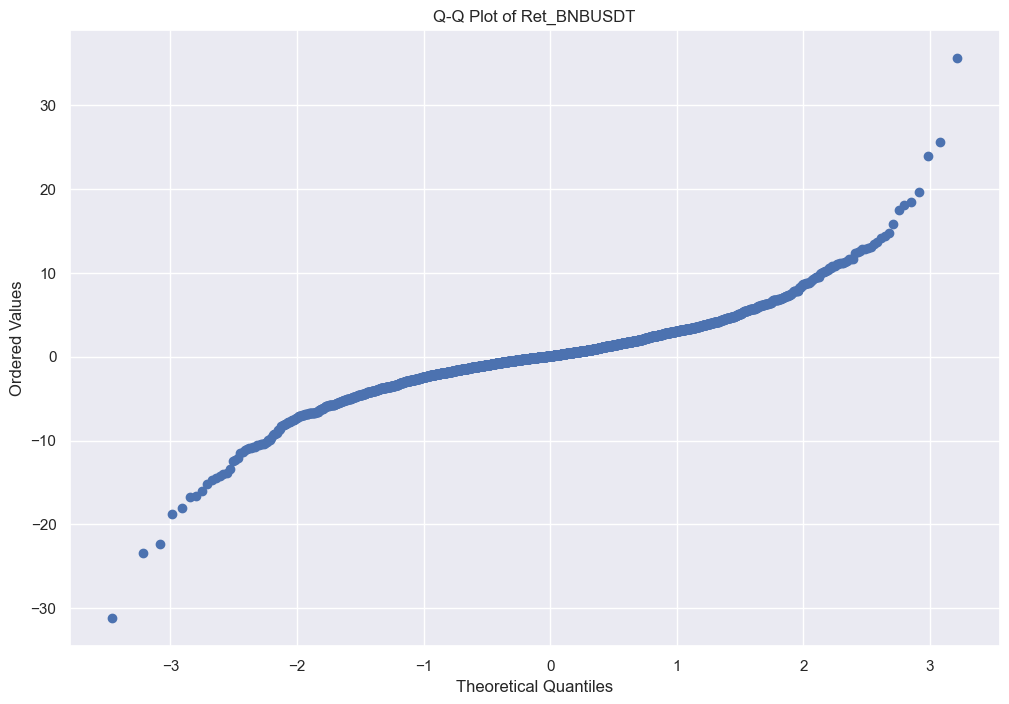

In [16]:
qqplot(df, 'Ret_BNBUSDT')

### The QQ Plot indicates that values are not normally distributed, more data in the 5000 to 2000 region 

## Test of stationality
##### ADF Test Results for BTCUSDT Closing Prices

The Augmented Dickey-Fuller (ADF) test was conducted on the BTCUSDT closing prices. The purpose of this test is to determine whether the series is stationary or non-stationary.

- Test Statistic: -1.465
- p-value: 0.55

The test statistic of -1.658 is less negative than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value of 0.453 is greater than the commonly used significance level of 0.05. These results indicate that there is insufficient evidence to reject the null hypothesis of non-stationarity.

Therefore, based on the ADF test, the BTCUSDT closing prices are likely non-stationary, suggesting the presence of trends or other forms of non-random behavior.


In [17]:
sts.adfuller(df.BTCUSDT)

(-0.7197777227456205,
 0.8415599381699996,
 23,
 2569,
 {'1%': -3.4328980132719673,
  '5%': -2.862665712019849,
  '10%': -2.567369257851913},
 41428.50916954582)

## Test of Seasonality

In [18]:
def seasonal_decompose_plots(df, column):
    result = seasonal_decompose(df[column].iloc[1:], model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    
    axes[0].plot(result.observed)
    axes[0].set_ylabel('Observed')
    
    axes[1].plot(result.trend)
    axes[1].set_ylabel('Trend')
    
    axes[2].plot(result.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    axes[3].plot(result.resid)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    
    # Generate the file name based on the column name
    file_name = f"{column}_decompose_additive.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()


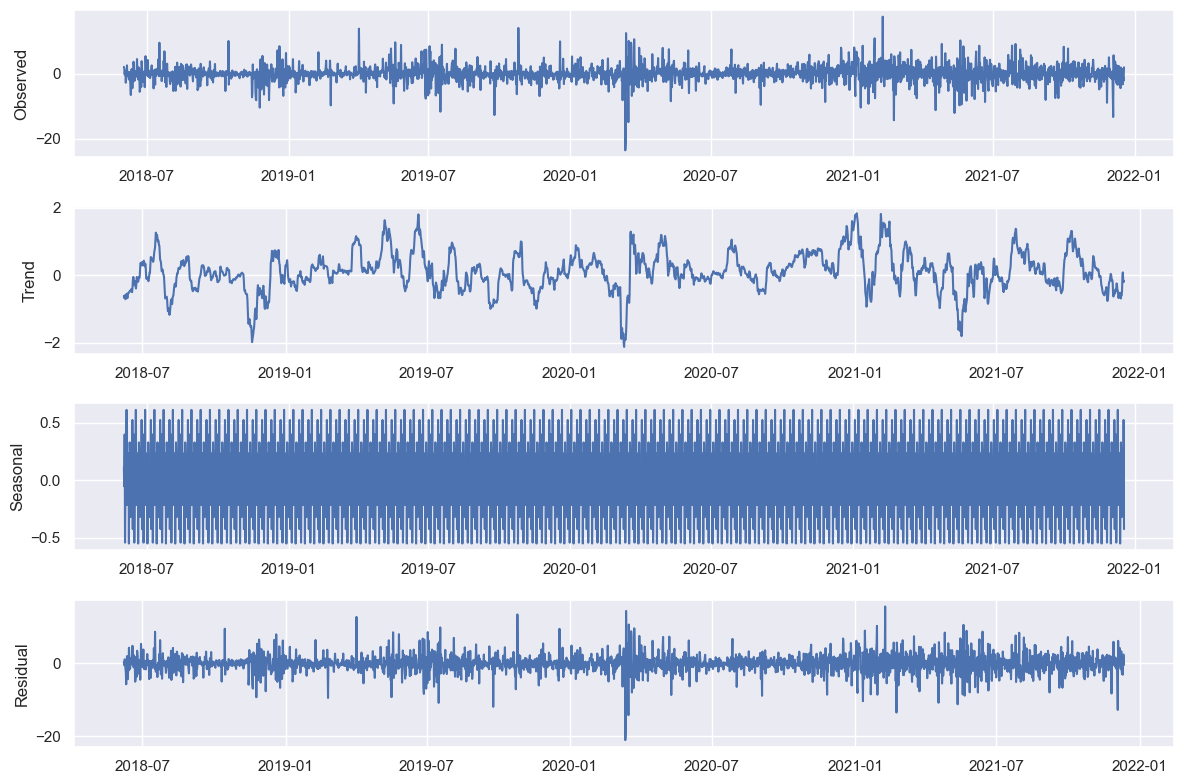

In [19]:
seasonal_decompose_plots(df, 'Ret_BTCUSDT')

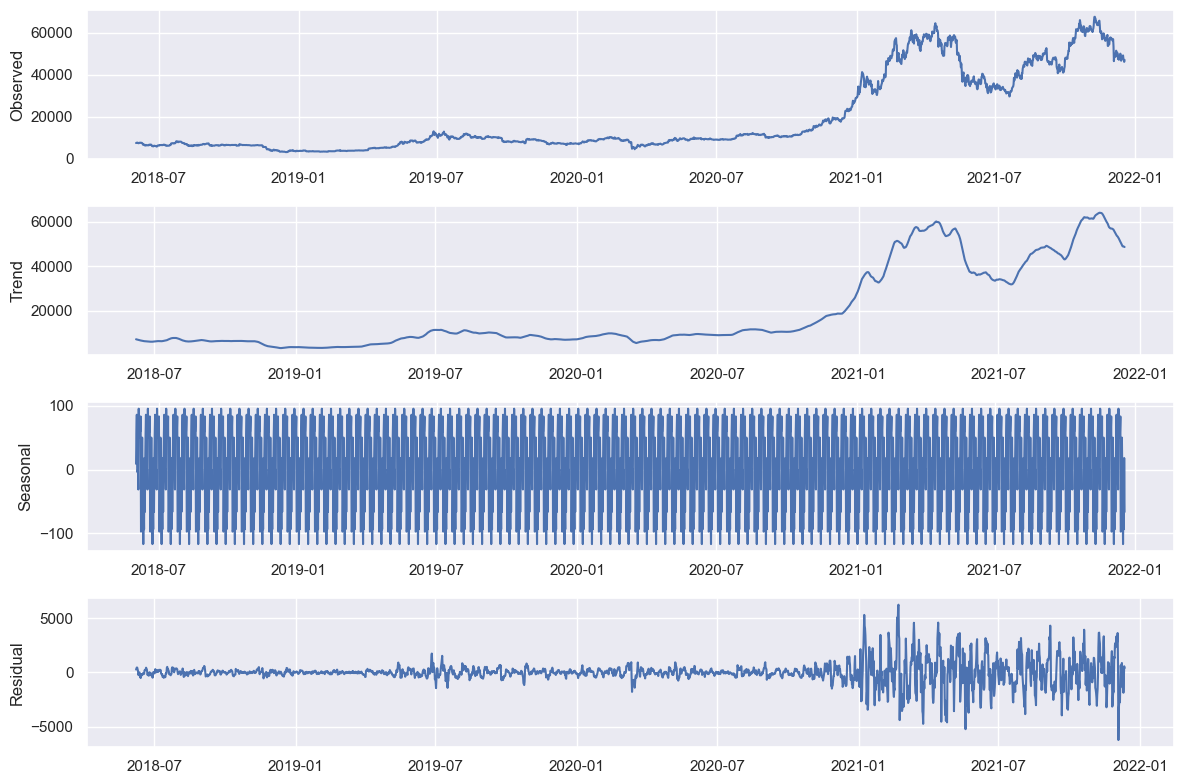

In [20]:
seasonal_decompose_plots(df,'BTCUSDT')

### seasonal decompose plot show that there is no seasonality in the data which means that the btcusdt is not a seasonal data also the residual shows that there was some instablity in the data in 2021 up untill eaily 2022

## Plotting ACF

In [21]:

def acf_plot(df, column, lags = 40):
    fig, ax = plt.subplots(figsize=(10, 8))
    sgt.plot_acf(df[column], lags = lags, zero=False, ax=ax)
    plt.title(f"{column} ACF")
    
    # Generate the file name based on the column name
    file_name = f"{column}_acf.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()


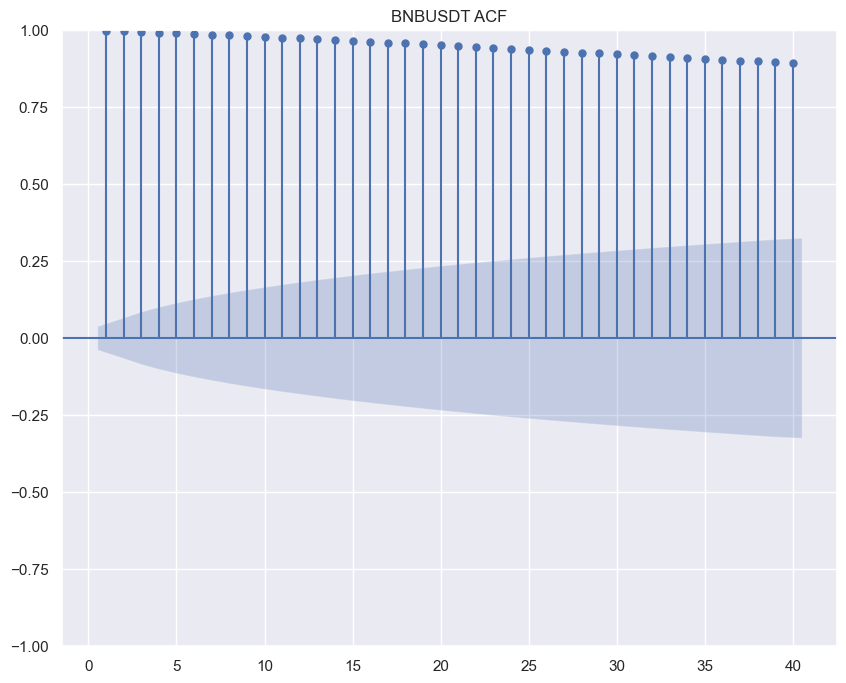

In [22]:
acf_plot(df, 'BNBUSDT')

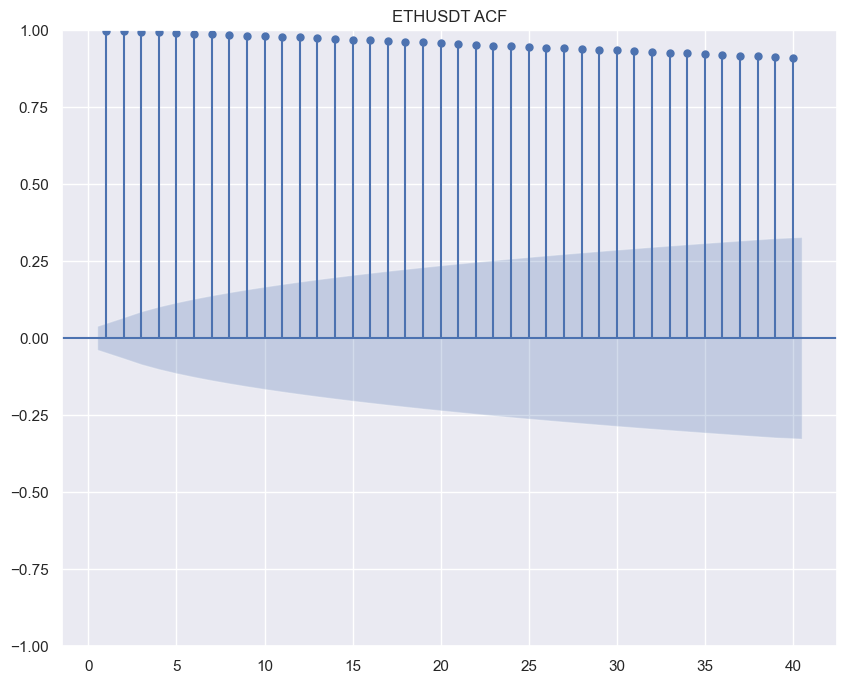

In [23]:
acf_plot(df, 'ETHUSDT', lags = 40)

### This acf suggest that coefficient are signficant which shows time dependance in the data also the shows that prices 30 days ago and beyond isnt really a good indicator of current prices

## PACF

In [24]:

def pacf_plot(df, column):
    fig, ax = plt.subplots(figsize=(10, 8))
    sgt.plot_pacf(df[column], lags=40, zero=False, ax=ax, method='ols')
    plt.title(f"{column} PACF", size=14)
    
    # Generate the file name based on the column name
    file_name = f"{column}_pacf.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()


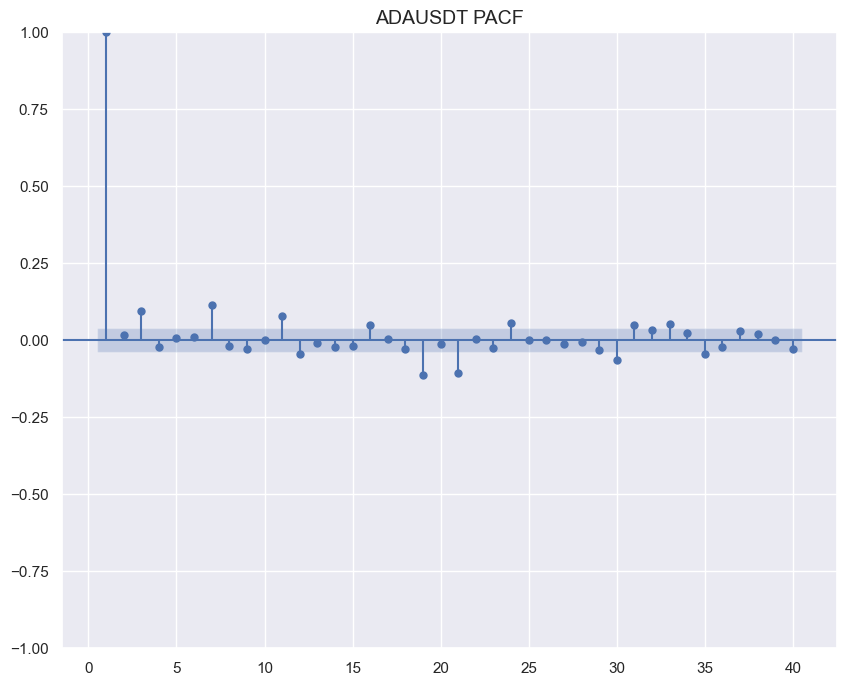

In [25]:
pacf_plot(df, 'ADAUSDT')

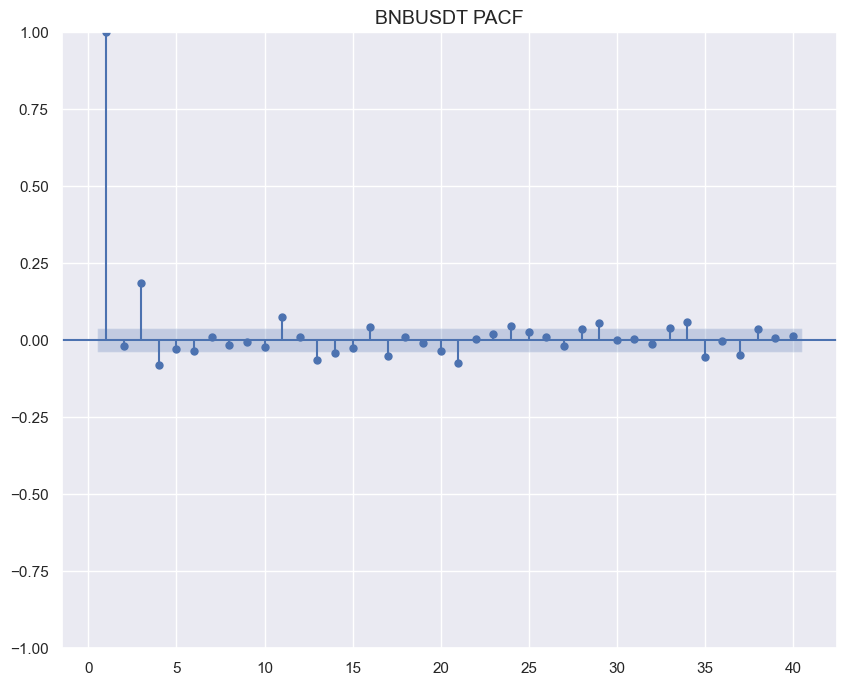

In [26]:
pacf_plot(df, 'BNBUSDT')

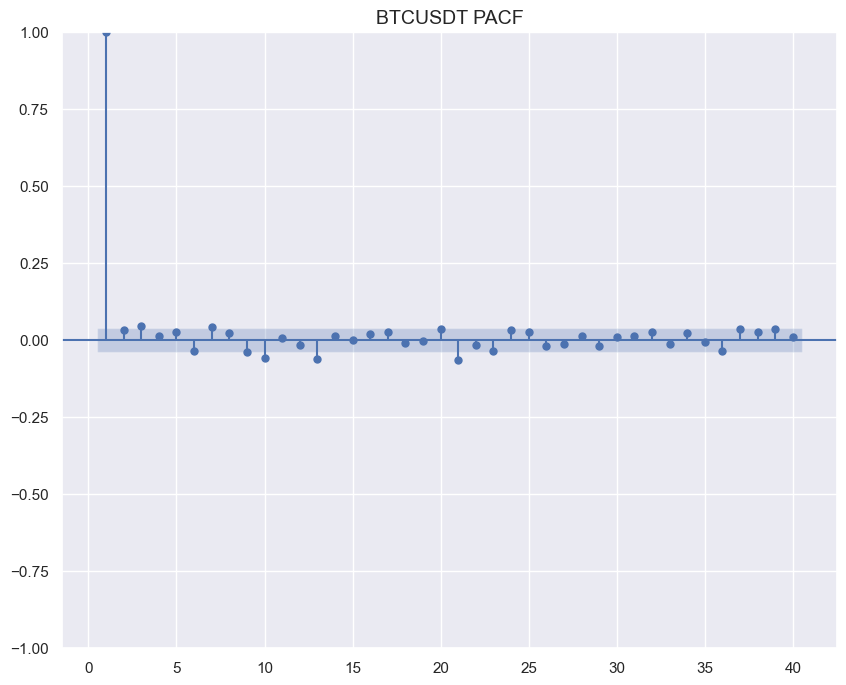

In [27]:
pacf_plot(df, 'BTCUSDT')

### the pacf shows that the previous lags has little to no effect on the current price 

In [28]:
def plot_correlation_heatmap(df, columns):
    selected_df = df[columns]
    
    # Compute the correlation matrix
    corr_matrix = selected_df.corr()
    
    # Create the heatmap plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    
    # Set the dynamic title based on the column names
    title = "Correlation Heatmap: " + ', '.join(columns)
    plt.title(title)
    
    
    file_name = "correlation_heatmap_" + '_'.join(columns) + ".png"
    plt.savefig(f'../reports/figures/{file_name}')
    
    plt.show()


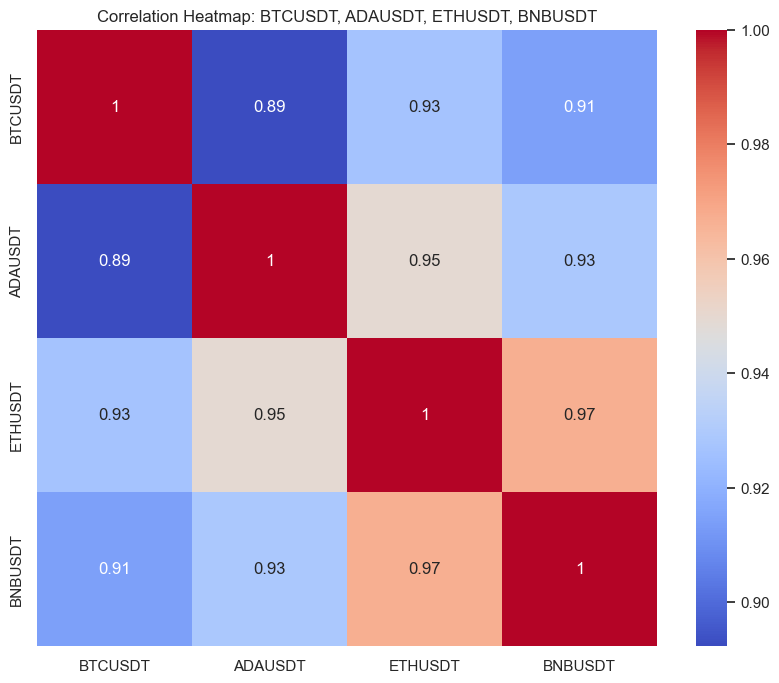

In [29]:
plot_correlation_heatmap(df, ['BTCUSDT', 'ADAUSDT', 'ETHUSDT', 'BNBUSDT'])

This headmap show that the crypto currencies in view are highly corrected with each which orther which is not expected of the looking closly the ada and btcusdt are the least corroected

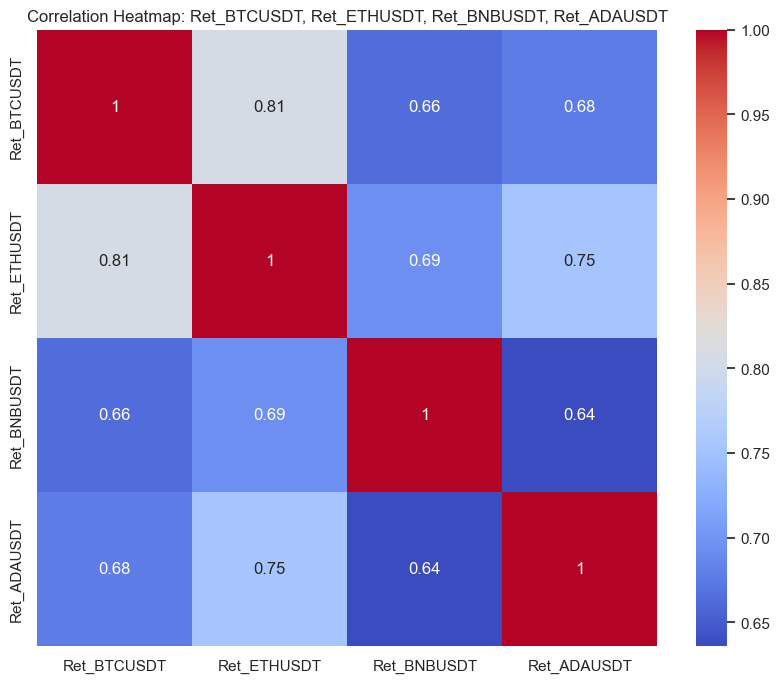

In [30]:
plot_correlation_heatmap(df, ['Ret_BTCUSDT', 'Ret_ETHUSDT', 'Ret_BNBUSDT', 'Ret_ADAUSDT'])

In [31]:

def outlier_detection(df, target_column, contamination=0.1):

    model = IsolationForest(contamination=contamination, random_state=42)

    # Fit the model and predict outliers
    df.dropna(inplace = True)
    df[f'outr_{target_column}'] = model.fit_predict(df[[target_column]])




In [32]:
outlier_detection(df, 'BTCUSDT')
outlier_detection(df, 'BNBUSDT')
outlier_detection(df, 'ETHUSDT')
outlier_detection(df, 'ADAUSDT')


c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [33]:

#for returns 
outlier_detection(df, 'Ret_cum_BTCUSDT')
outlier_detection(df, 'Ret_cum_ADAUSDT')
outlier_detection(df, 'Ret_cum_ETHUSDT')
outlier_detection(df, 'Ret_cum_BNBUSDT')


c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\Time_Series\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [34]:

def plot_outliers(df, target_column):
    
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot the data
    ax.plot(df.index, df[target_column], label= target_column, c = 'green')

    # Mark the outliers
    outliers = df[df[f'outr_{target_column}'] == -1]
    ax.scatter(outliers.index, outliers[target_column], color='red', label='Outliers')

    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Outlier Detection for {target_column}', fontsize = 20)
    ax.legend()
    plt.savefig(f'../reports/figures/{target_column}_outliers.png')
    plt.show()



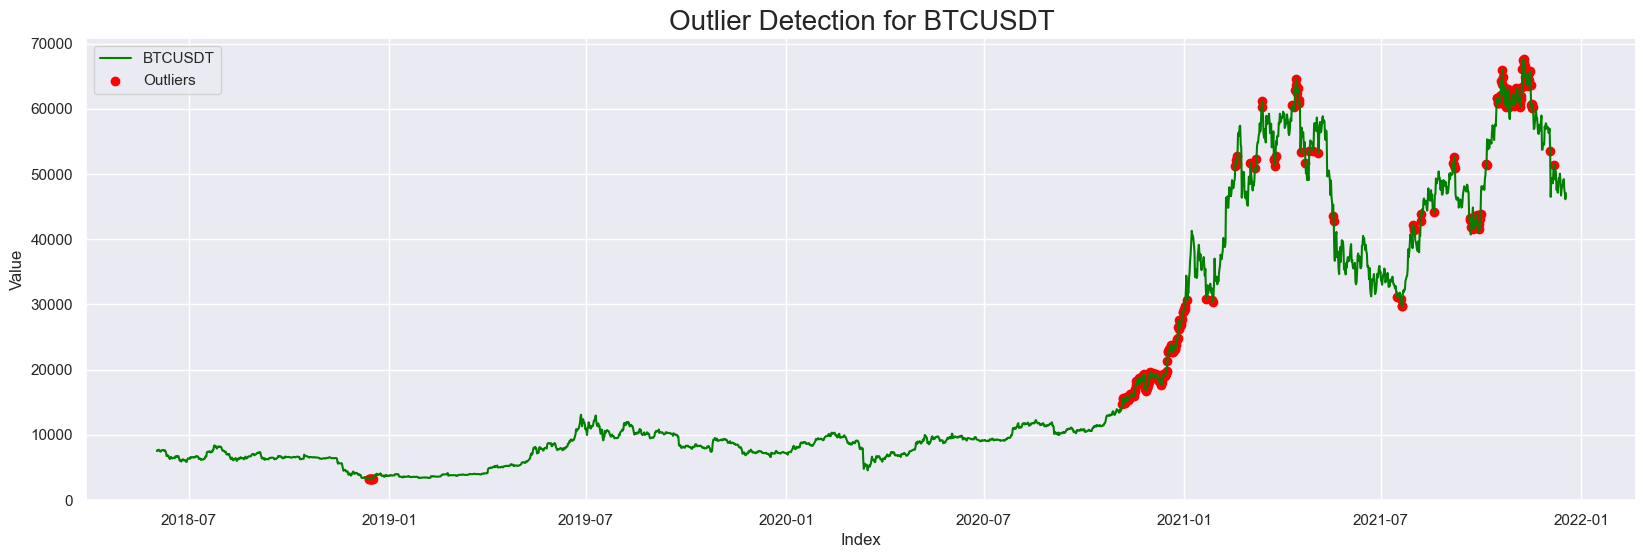

In [35]:

plot_outliers(df, 'BTCUSDT')


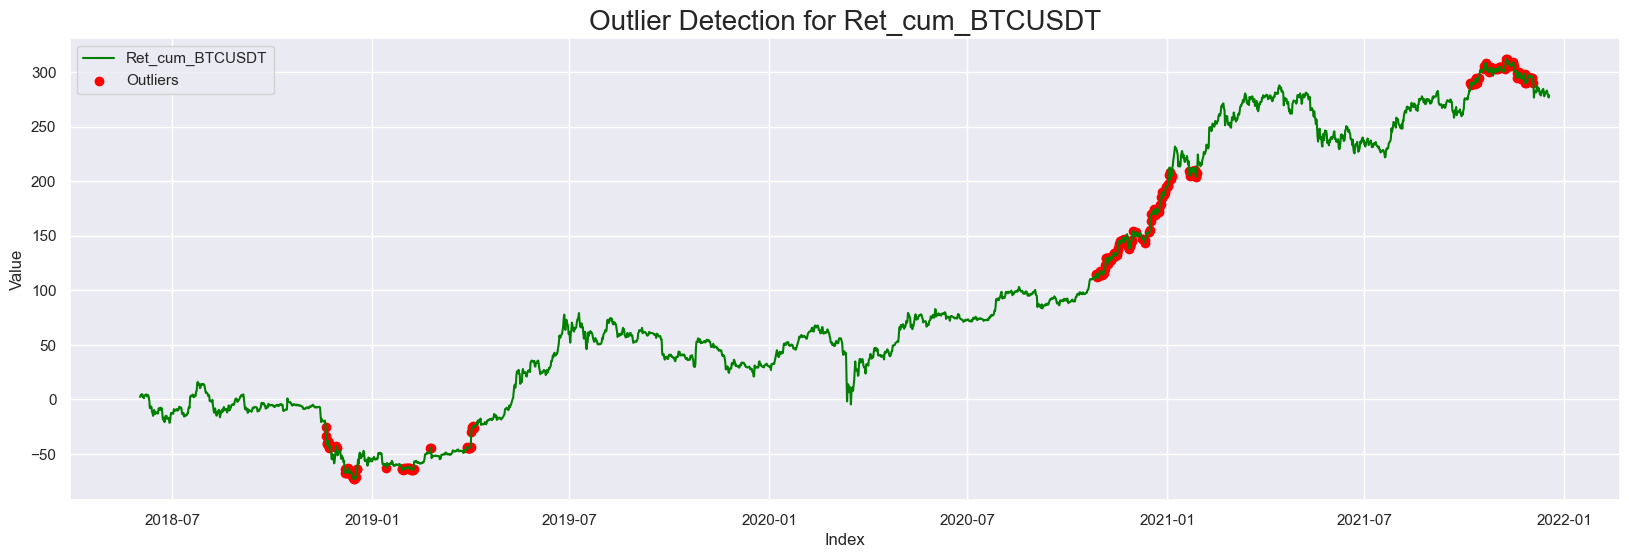

In [36]:
plot_outliers(df, 'Ret_cum_BTCUSDT')

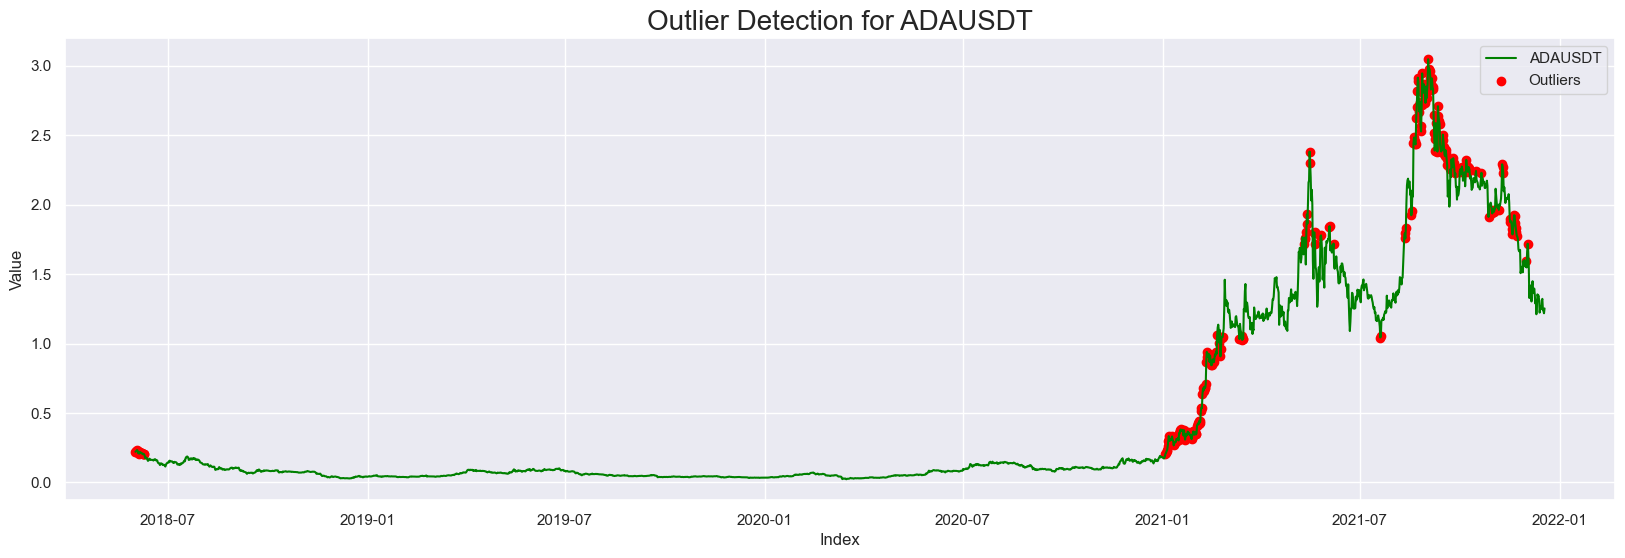

In [37]:
plot_outliers(df, 'ADAUSDT')

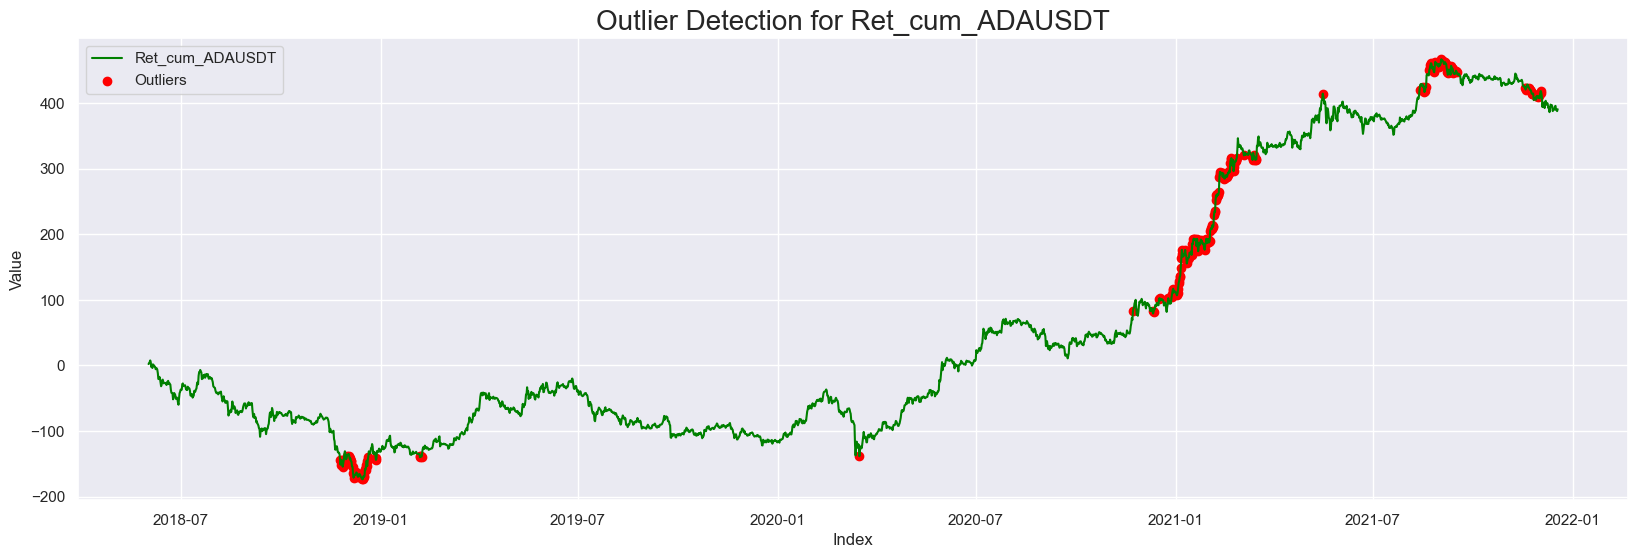

In [38]:
plot_outliers(df, 'Ret_cum_ADAUSDT')

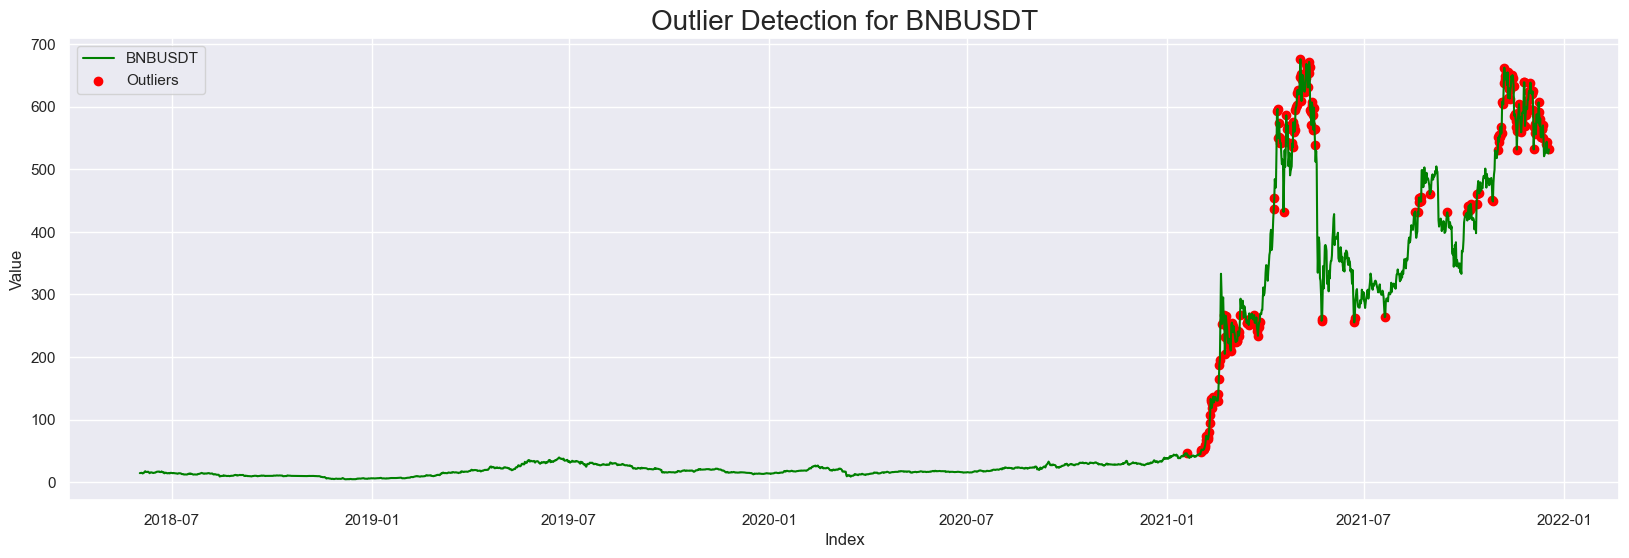

In [39]:
plot_outliers(df, 'BNBUSDT')

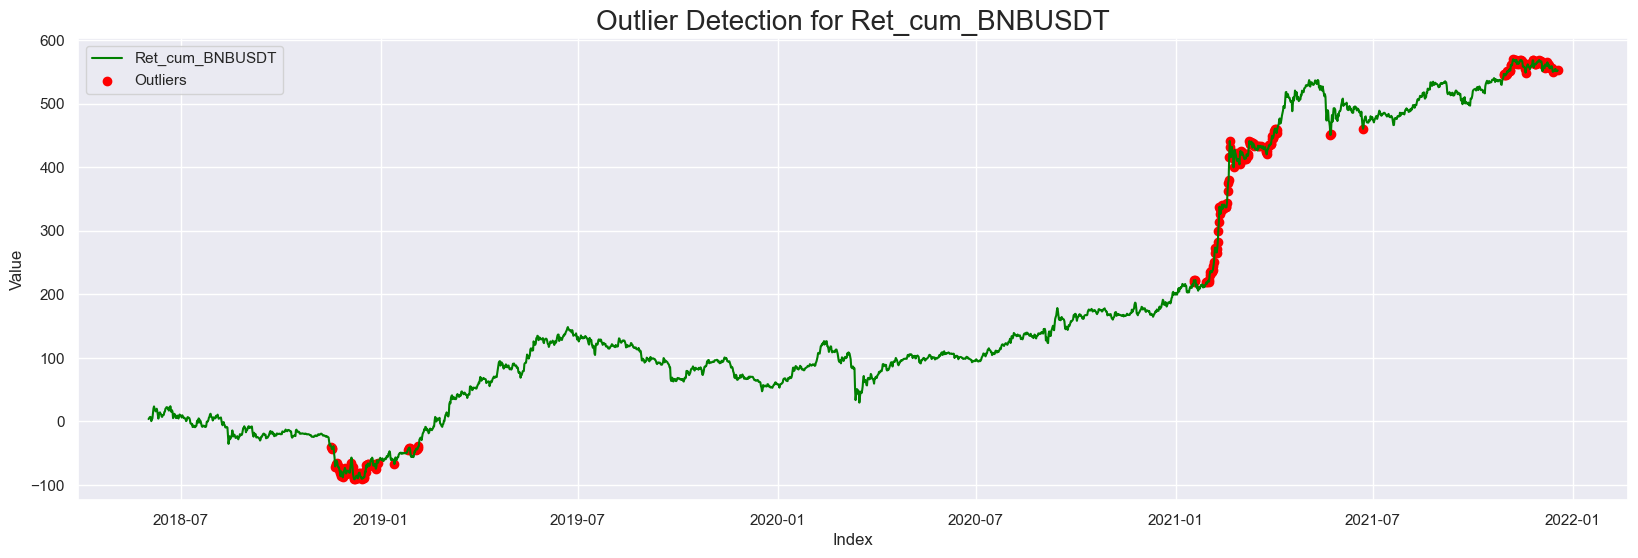

In [40]:
plot_outliers(df, 'Ret_cum_BNBUSDT')

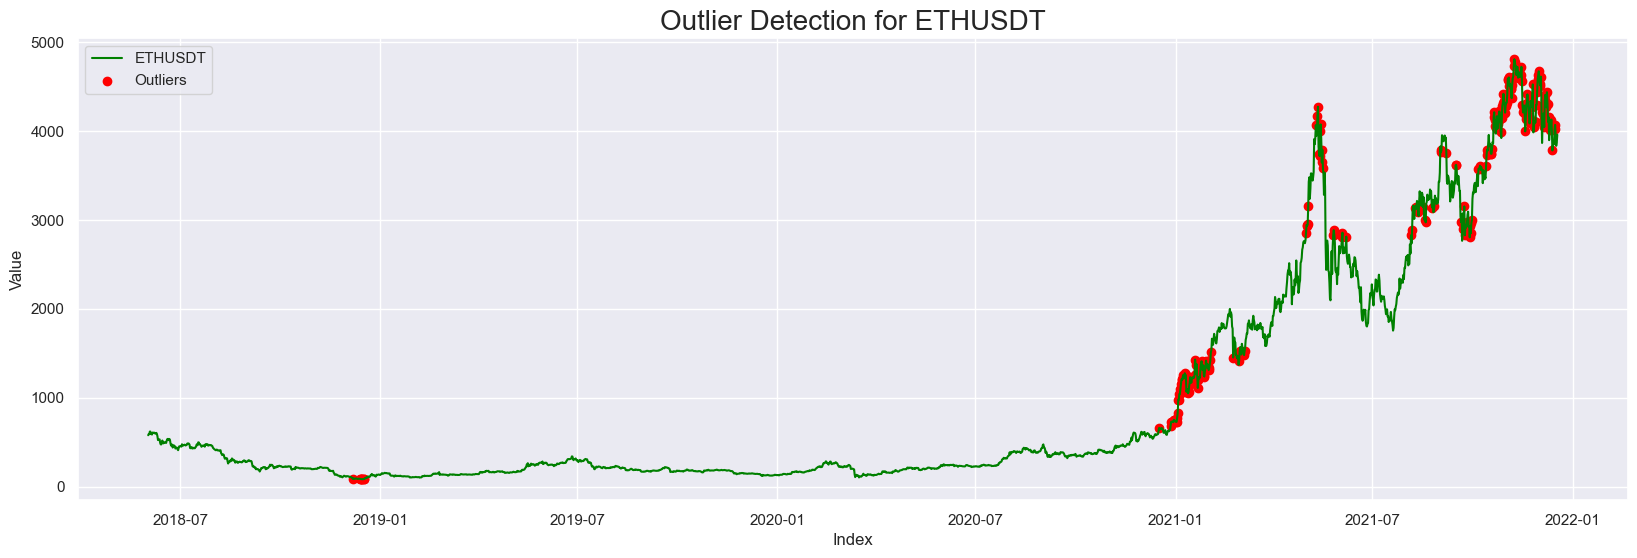

In [41]:
plot_outliers(df, 'ETHUSDT')

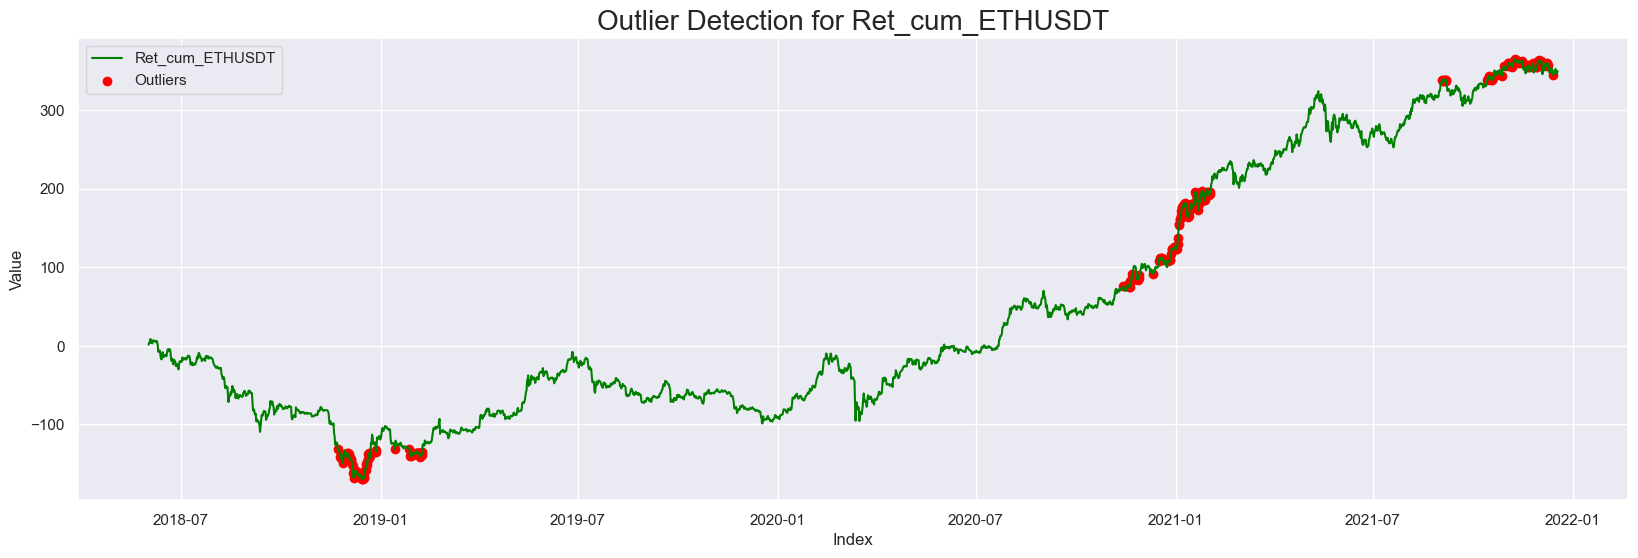

In [42]:
plot_outliers(df, 'Ret_cum_ETHUSDT')

##### Analyising volititlity

In [73]:
def garch_volatility(df, column):
    """
    Fit and plot the GARCH model's estimated volatility.

    Parameters:
        df (DataFrame): DataFrame containing the return series.
        column (str): Name of the column with the return series.

    """
    # Create a GARCH model
    model = arch.arch_model(df[f'Ret_{column}'], vol='Garch', p=1, q=1)

    # Fit the model
    results = model.fit(update_freq=5)

    # Print the model summary
    print(results.summary())

    # Plot the estimated volatility
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(results.conditional_volatility, color='blue', label=f'Estimated Volatility for {column}')
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Volatility', fontsize = 17)
    ax.set_title(f'GARCH Estimated Volatility {column}', fontsize = 20)
    ax.legend()
    plt.savefig(f'../reports/figures/Ret_{column}_garch.png')
    plt.show()


Iteration:      5,   Func. Count:     41,   Neg. LLF: 6042.725552874173
Iteration:     10,   Func. Count:     66,   Neg. LLF: 6042.567397166942
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6042.567397166942
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Ret_BTCUSDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6042.57
Distribution:                  Normal   AIC:                           12093.1
Method:            Maximum Likelihood   BIC:                           12116.6
                                        No. Observations:                 2592
Date:                Tue, Jun 27 2023   Df Residuals:                     2591
Time:          

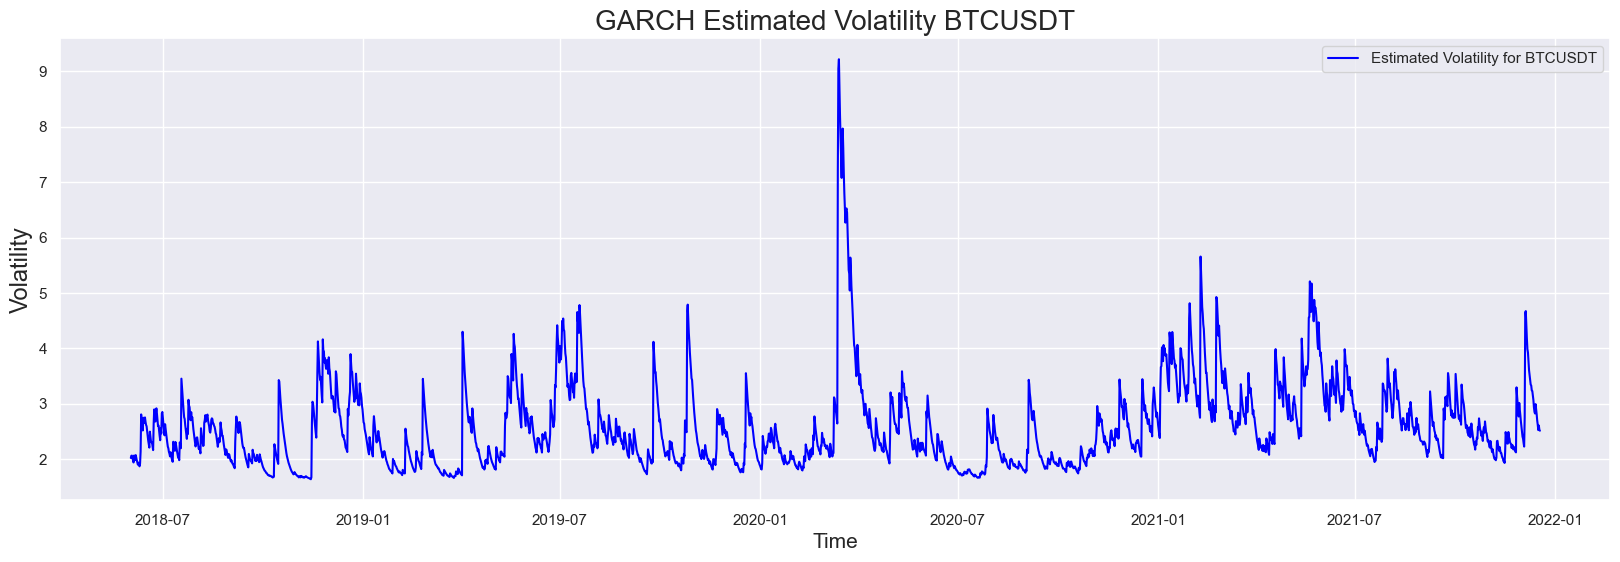

In [74]:
garch_volatility(df, 'BTCUSDT')

Iteration:      5,   Func. Count:     32,   Neg. LLF: 7376.740768101924
Iteration:     10,   Func. Count:     60,   Neg. LLF: 7151.37612664454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7151.376082066814
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Ret_ADAUSDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7151.38
Distribution:                  Normal   AIC:                           14310.8
Method:            Maximum Likelihood   BIC:                           14334.2
                                        No. Observations:                 2592
Date:                Tue, Jun 27 2023   Df Residuals:                     2591
Time:           

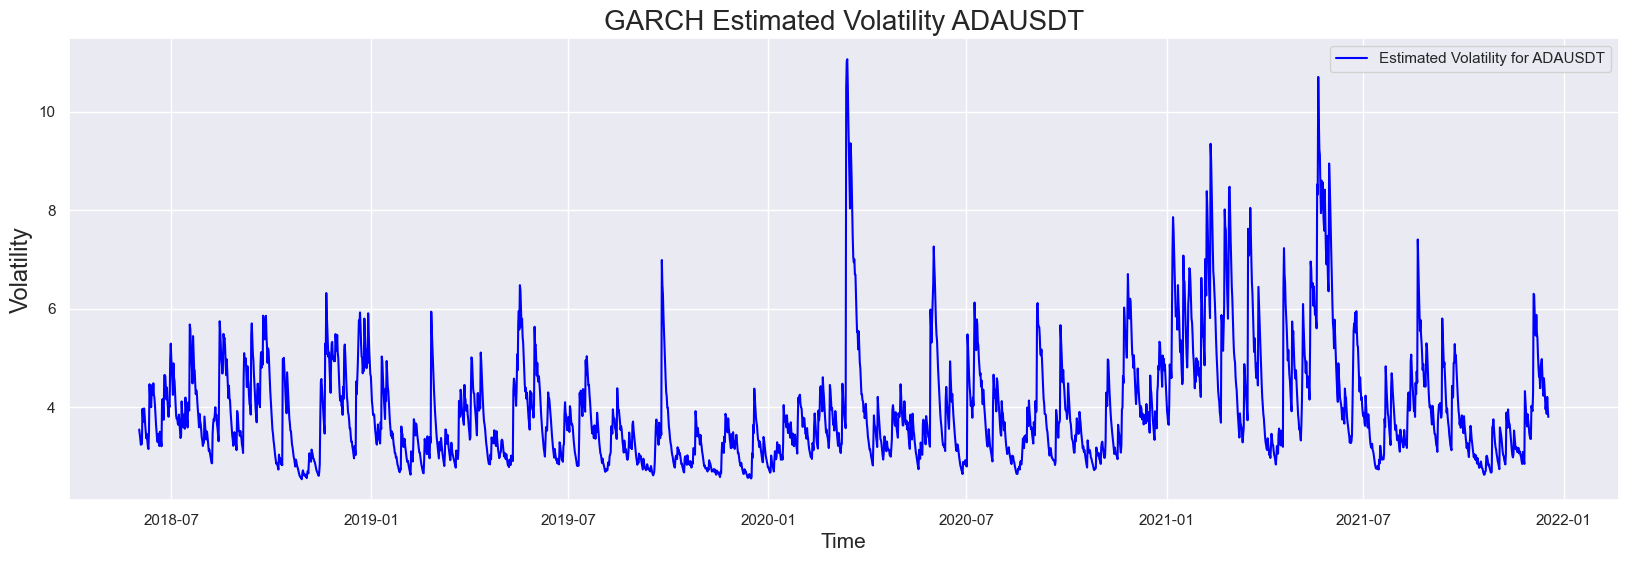

In [76]:
garch_volatility(df, 'ADAUSDT')


Iteration:      5,   Func. Count:     37,   Neg. LLF: 6787.760809488673
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6787.4369759566325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6787.4369759566325
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Ret_BNBUSDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6787.44
Distribution:                  Normal   AIC:                           13582.9
Method:            Maximum Likelihood   BIC:                           13606.3
                                        No. Observations:                 2592
Date:                Tue, Jun 27 2023   Df Residuals:                     2591
Time:        

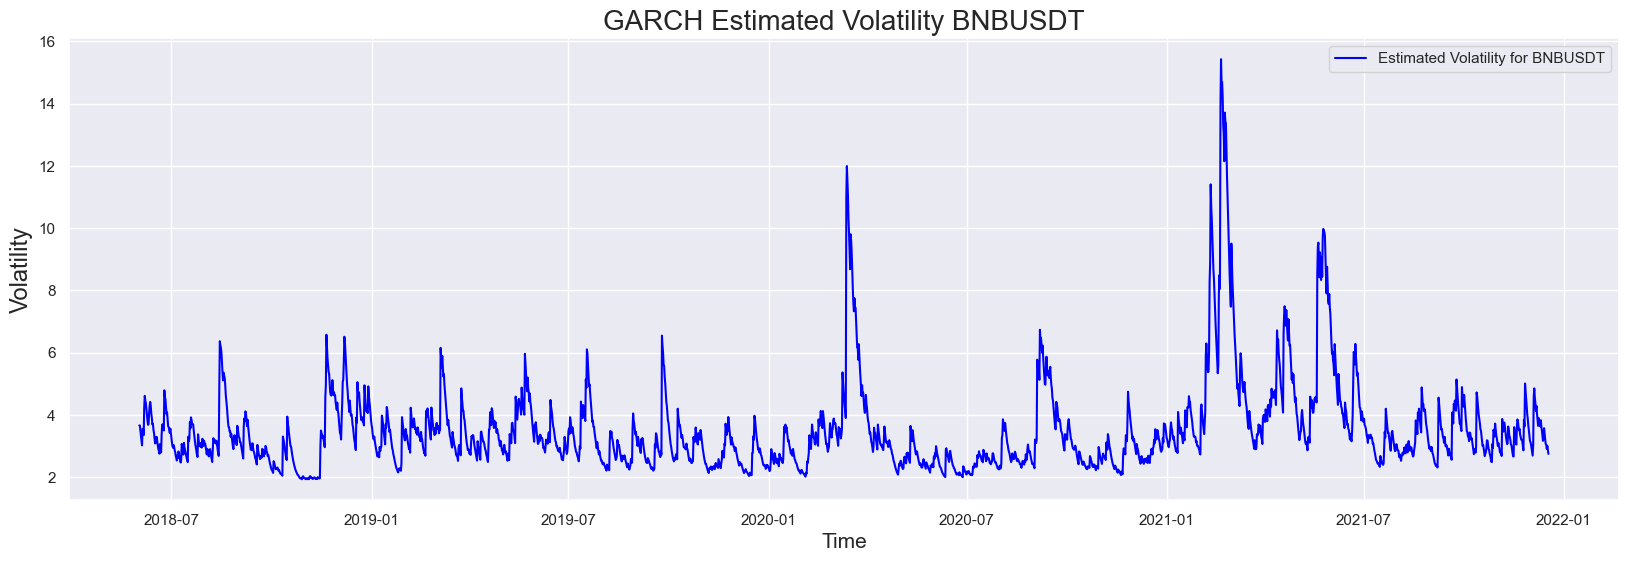

In [77]:
garch_volatility(df, 'BNBUSDT')


Iteration:      5,   Func. Count:     32,   Neg. LLF: 695830811.9186147
Iteration:     10,   Func. Count:     61,   Neg. LLF: 6708.680754873141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6708.680717520079
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Ret_ETHUSDT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6708.68
Distribution:                  Normal   AIC:                           13425.4
Method:            Maximum Likelihood   BIC:                           13448.8
                                        No. Observations:                 2592
Date:                Tue, Jun 27 2023   Df Residuals:                     2591
Time:          

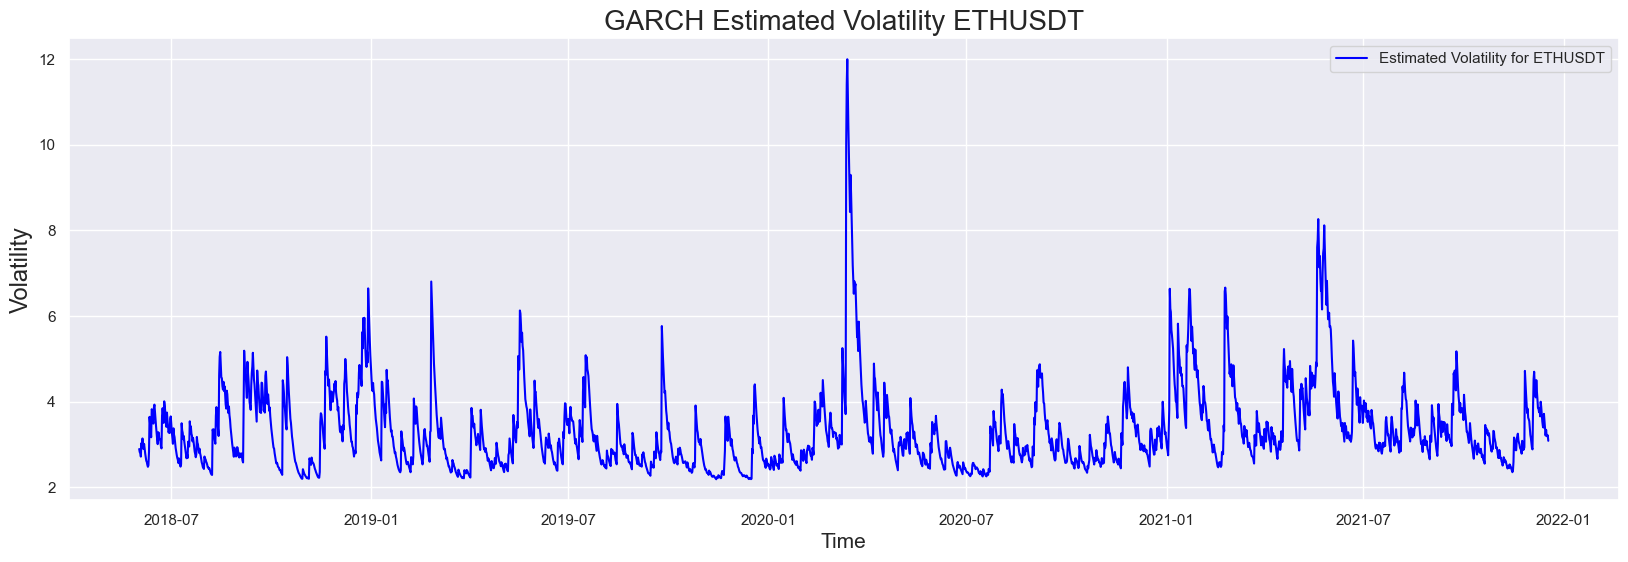

In [78]:
garch_volatility(df, 'ETHUSDT')